In [ ]:

api=KaggleApi()
api.authenticate()
os.mkdir("data")
l=["train.csv","test.csv","store.csv"]
for i in l:
    api.competition_download_file("rossmann-store-sales",i,force=True)

# IMPORTS

## packages

In [1]:
import dtale, os, atom, shap, pickle, inflection, datetime, math
import pandas as pd
import numpy as np
import kaggle
import seaborn as sns
import xgboost as xgb
import zipfile
import matplotlib.pyplot as plt
import xgboost as xgb
import scipy.stats as ss


from sklearn.preprocessing              import RobustScaler,MinMaxScaler
from sklearn.base                       import BaseEstimator, TransformerMixin
from sklearn.preprocessing              import LabelEncoder
from IPython.display                    import Image
from sklearn.linear_model               import LinearRegression, Lasso
from sklearn.ensemble                   import RandomForestRegressor
from sklearn.metrics                    import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from boruta                             import BorutaPy
from sklearn.pipeline                   import Pipeline
from kaggle.api.kaggle_api_extended     import KaggleApi


pd.options.display.max_columns = 500 # this will set limit of columns to 500
%matplotlib inline
os.getcwd()

'p:\\Python\\GitHub\\forecast_sales'

## helper classes

In [2]:
class filtrator(BaseEstimator, TransformerMixin):
    def __init__(self,mapper_in=None,mapper_out=None):
        self.mapper_in=mapper_in
        self.mapper_out=mapper_out
        return None
    
    def fit(self, X, y=None):
        return self  # nothing else to do
    
    def transform(self,X):
        X2=X.copy()
        if self.mapper_in !=None:
            for k,v in self.mapper_in.items():
                X2=X2[X2[k].isin(v)]
        else: pass
        if self.mapper_out !=None:
            for k,v in self.mapper_out.items():
                X2=X2[~X2[k].isin(v)]
        pass
        return X2

In [3]:
class cols_selector(BaseEstimator, TransformerMixin):
    def __init__(self,sel=None,drop=None):
        self.sel=sel
        self.drop=drop
        return None
    
    def fit(self, X, y=None):
        return self  # nothing else to do
    
    def transform(self,X):
        if self.sel !=None:
            X2=X.copy()
            X2=X2[self.sel]
        else:
            X2=X.copy()
            X2=X2.drop(self.drop,axis=1)
        return X2

In [4]:
class dtypes(BaseEstimator, TransformerMixin):
    def __init__(self,dict_cols=None):
        self.dict_cols=dict_cols
        return None
    
    def fit(self, X, y=None):
        return self  # nothing else to do
    
    def transform(self,X):
        X2=X.copy()
        for k,v in self.dict_cols.items():
            X2[k]=X2[k].astype(v)
        return X2

## helper funcions 

In [5]:
def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

In [6]:
def errors_ml(ytrue=None,ypred=None,model_name=None):
    mae_baseline=mean_absolute_error(np.expm1(ytrue),np.expm1(ypred))
    mape_baseline=mean_absolute_percentage_error(np.expm1(ytrue),np.expm1(ypred))
    mse_baseline=mean_squared_error(np.expm1(ytrue),np.expm1(ypred))
    rmse_baseline=np.sqrt(mse_baseline)
    results=pd.DataFrame(data={'model_name':model_name,'mae':mae_baseline,'mape':mape_baseline,'mse':mse_baseline,'rmse':rmse_baseline}, index=[0])
    return results

In [7]:
def cross_validation( x_training, kfold, model_name, model, verbose=False ):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed( range( 1, kfold+1 ) ):
        if verbose:
            print( '\nKFold Number: {}'.format( k ) )
        # start and end date for validation 
        validation_start_date = x_training['date'].max() - datetime.timedelta( days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta( days=(k-1)*6*7)

        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # training and validation dataset
        # training
        xtraining = training.drop( ['date', 'sales'], axis=1 ) 
        ytraining = training['sales']

        # validation
        xvalidation = validation.drop( ['date', 'sales'], axis=1 )
        yvalidation = validation['sales']

        # model
        m = model.fit( xtraining, ytraining )

        # prediction
        yhat = m.predict( xvalidation )

        # performance
        m_result = errors_ml( model_name, np.expm1( yvalidation ), np.expm1( yhat ) )




        # store performance of each kfold iteration
        mae_list.append(  m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )

    return pd.DataFrame( {'Model Name': model_name,
                          'MAE CV': np.round( np.mean( mae_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
                          'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),
                          'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str ) }, index=[0] )

In [8]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [30, 16]
    plt.rcParams['font.size'] = 24
    
    #display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )

    sns.set()

jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## data import

In [66]:
train=pd.read_csv(r"data/train.csv",parse_dates=['Date'])
test=pd.read_csv(r"data/test.csv",parse_dates=['Date'])
store=pd.read_csv("data/store.csv")
train.head(1)


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1


In [67]:
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [68]:
df0=train.merge(store,how='left',on='Store',validate='many_to_one')
assert train.shape[0]==df0.shape[0]
df0.head(1)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN


# DATA DESCRIPTION

In [69]:
df1=df0.copy()
cols_old=df1.columns
snakecase = lambda x: inflection.underscore(x)
cols_new = list ( map( snakecase, cols_old))

#rename
df1.columns = cols_new

In [118]:
df0['Date'].describe()

count                 1017209
unique                    942
top       2015-07-31 00:00:00
freq                     1115
first     2013-01-01 00:00:00
last      2015-07-31 00:00:00
Name: Date, dtype: object

## data cleaning

In [73]:

#competition_distance
df1['competition_distance'] = df1['competition_distance'].apply( lambda x:200000.0 if math.isnan( x ) else x )
#competition_open_since_month
df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 )
#competition_open_since_year
df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1 )
#promo2_since_week
df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan(x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )
#promo2_since_year
df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan(x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )



#promo_interval
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',7: 'Jul', 8: 'Aug', 9: 'Sept', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
df1['promo_interval'].fillna(0, inplace=True )
df1['month_map'] = df1['date'].dt.month.map( month_map )
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 \
    if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )

df1.head()


,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,31.0,2015.0,0,Jul,0
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",Jul,1
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",Jul,1
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,31.0,2015.0,0,Jul,0
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,31.0,2015.0,0,Jul,0


## change Types

In [74]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [75]:
for i in ["competition_open_since_month","competition_open_since_year","promo2_since_week","promo2_since_year"]:
    df1[i]=df1[i].astype(int)

## descriptive statistical

In [76]:
num_cols=df1.select_dtypes(include=['int64','float64'])
num_cols.agg(["mean","median","std","min","max","skew","kurtosis"]).T


,mean,median,std,min,max,skew,kurtosis
store,558.429727,558.0,321.908651,1.0,1115.0,-0.000955,-1.200524
day_of_week,3.998341,4.0,1.997391,1.0,7.0,0.001593,-1.246873
sales,5773.818972,5744.0,3849.926175,0.0,41551.0,0.641460,1.778375
customers,633.145946,609.0,464.411734,0.0,7388.0,1.598650,7.091773
open,0.830107,1.0,0.375539,0.0,1.0,-1.758045,1.090723
promo,0.381515,0.0,0.485759,0.0,1.0,0.487838,-1.762018
school_holiday,0.178647,0.0,0.383056,0.0,1.0,1.677842,0.815154
competition_distance,5935.442677,2330.0,12547.652996,20.0,200000.0,10.242344,147.789712
promo2,0.500564,1.0,0.500000,0.0,1.0,-0.002255,-1.999999
is_promo,0.171835,0.0,0.377237,0.0,1.0,1.739838,1.027039


## describe sales per cat attributes

In [77]:
cat_cols=df1.select_dtypes(include='object')
cat_cols.nunique()

state_holiday      5
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

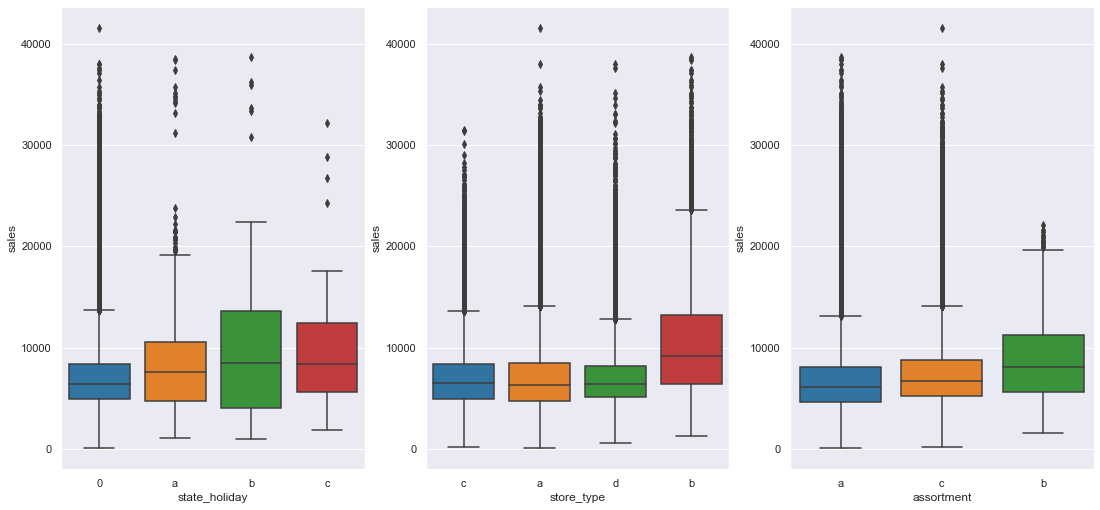

In [78]:
mask1=(df1['state_holiday']!=0) & (df1['sales']>0)
plt.subplot(1,3,1)
sns.boxplot(x='state_holiday',y='sales',data=df1[mask1],palette='tab10')

plt.subplot(1,3,2)
sns.boxplot(x='store_type',y='sales',data=df1[mask1],palette='tab10')

plt.subplot(1,3,3)
sns.boxplot(x='assortment',y='sales',data=df1[mask1],palette='tab10')


fig = plt.gcf()
fig.set_size_inches(18.5, 8.5)

# HYPOTESES CREATION

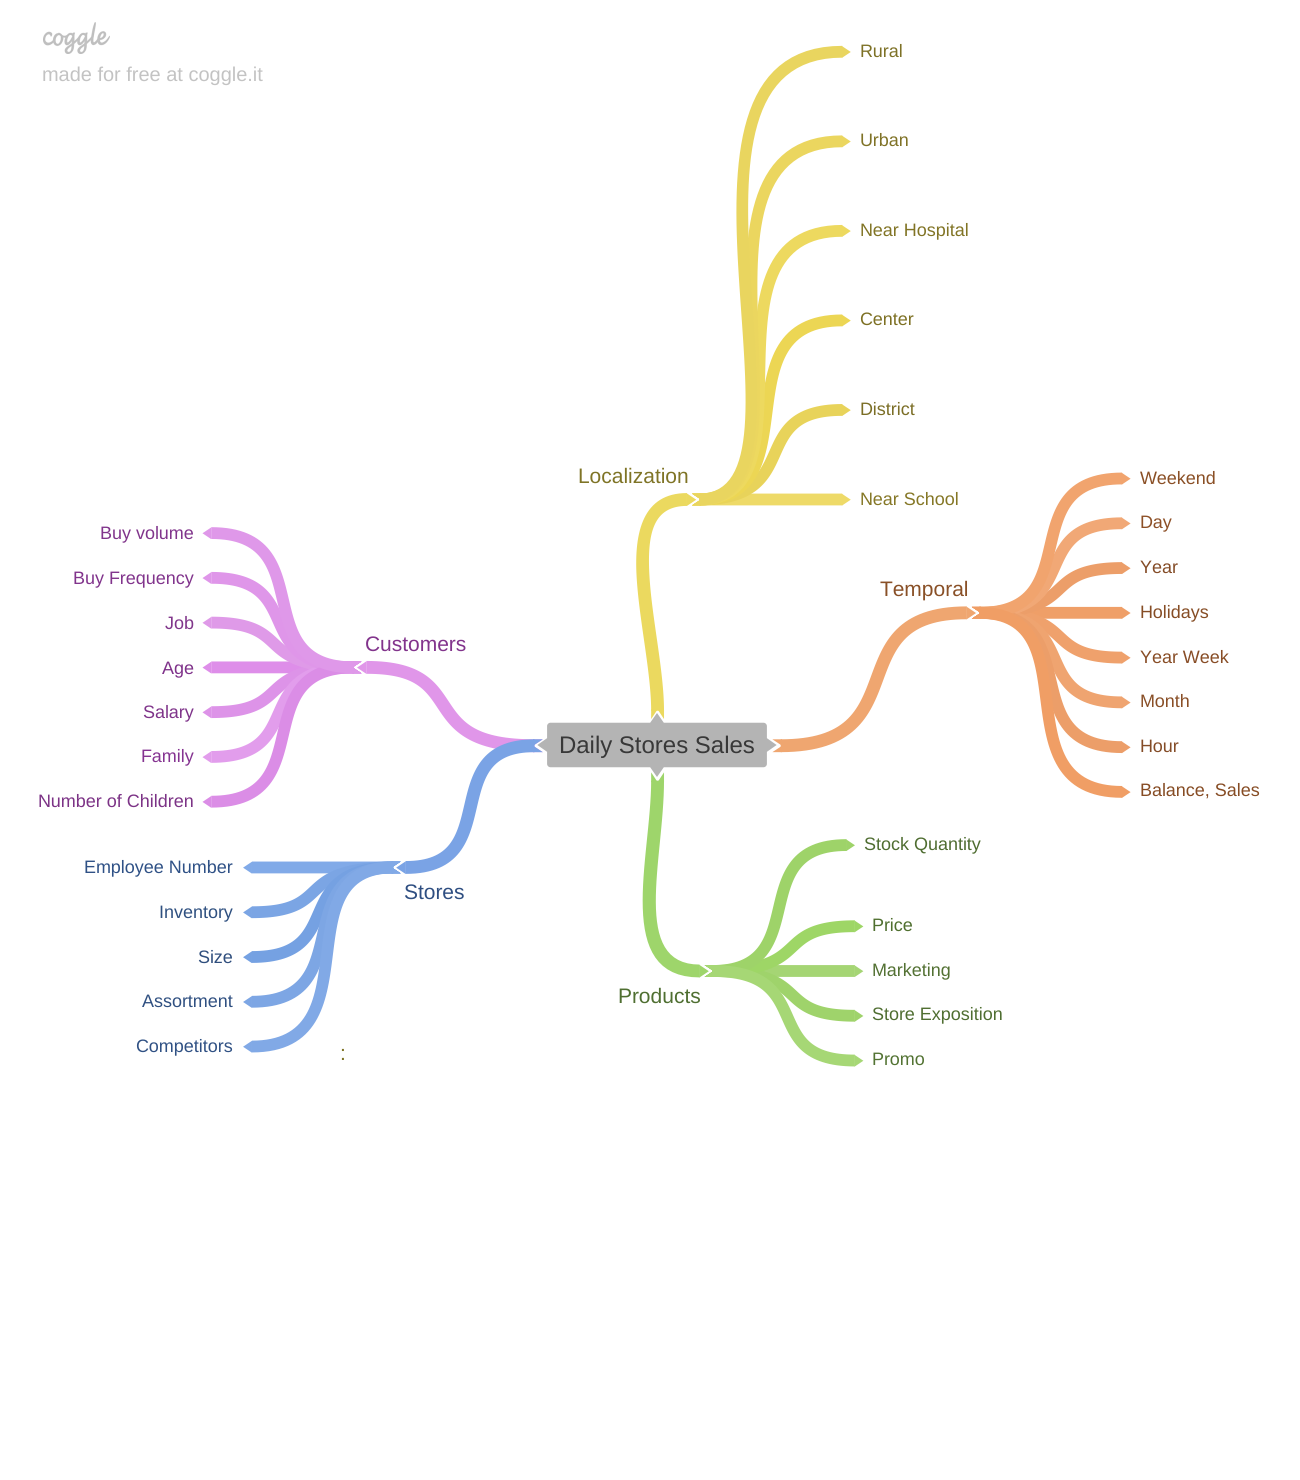

In [79]:
Image('img/Daily_Stores_Sales.png')

# FEATURE ENGINEERING

In [80]:
df2=df1.copy()

In [81]:

# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

# year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

# competition since
df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1 ), axis=1 )
df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( int )

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( int )

# assortment
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )

In [82]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# FEATURE FILTER

In [83]:
# In this section we must drop all features which would not me available in production i.e "promo interval" and "customers".

In [84]:
df3=df2.copy()

## row filtering

In [85]:
#only open stores and with at least one sale
df3=df3[(df3['open']!=0) & (df3['sales']>0)]

## cols filtering

In [86]:
cols_drop = ['customers','open','promo_interval','month_map']
df3=df3.drop(cols_drop,axis=1)

In [87]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# UNIVARIATE ANALYSIS

In [88]:
df4=df3.copy()

## numeric

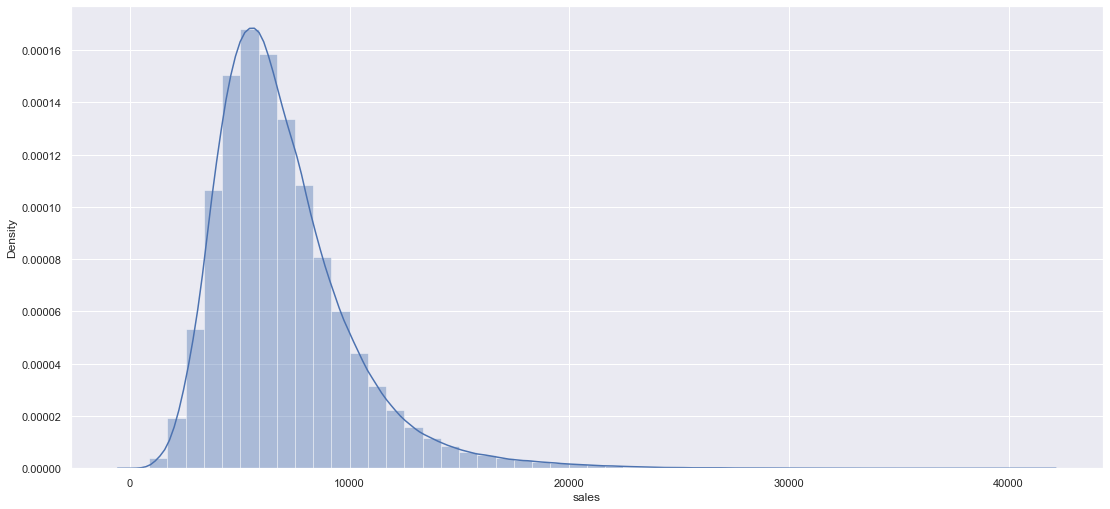

In [89]:
sns.distplot(df4['sales'])
fig = plt.gcf()
fig.set_size_inches(18.5, 8.5)


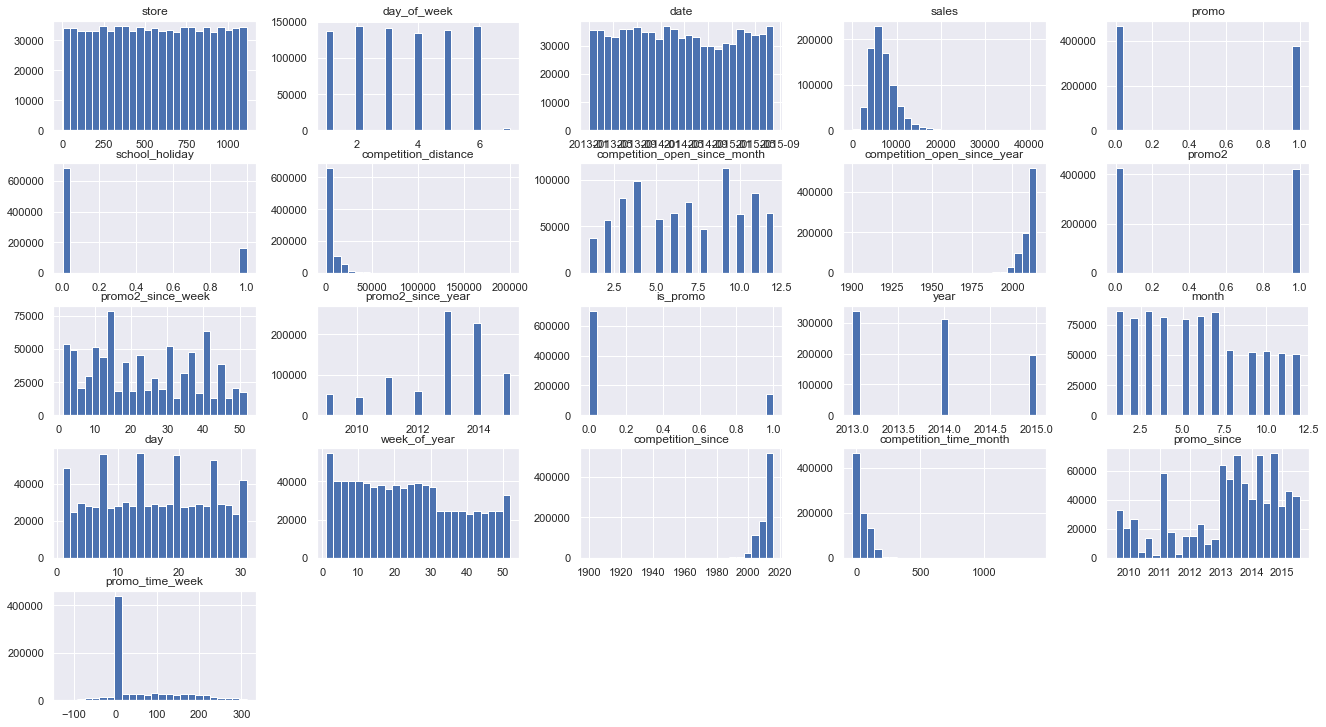

In [90]:
df4.hist(bins=25)
fig = plt.gcf()
fig.set_size_inches(22.5, 12.5)

## categoric

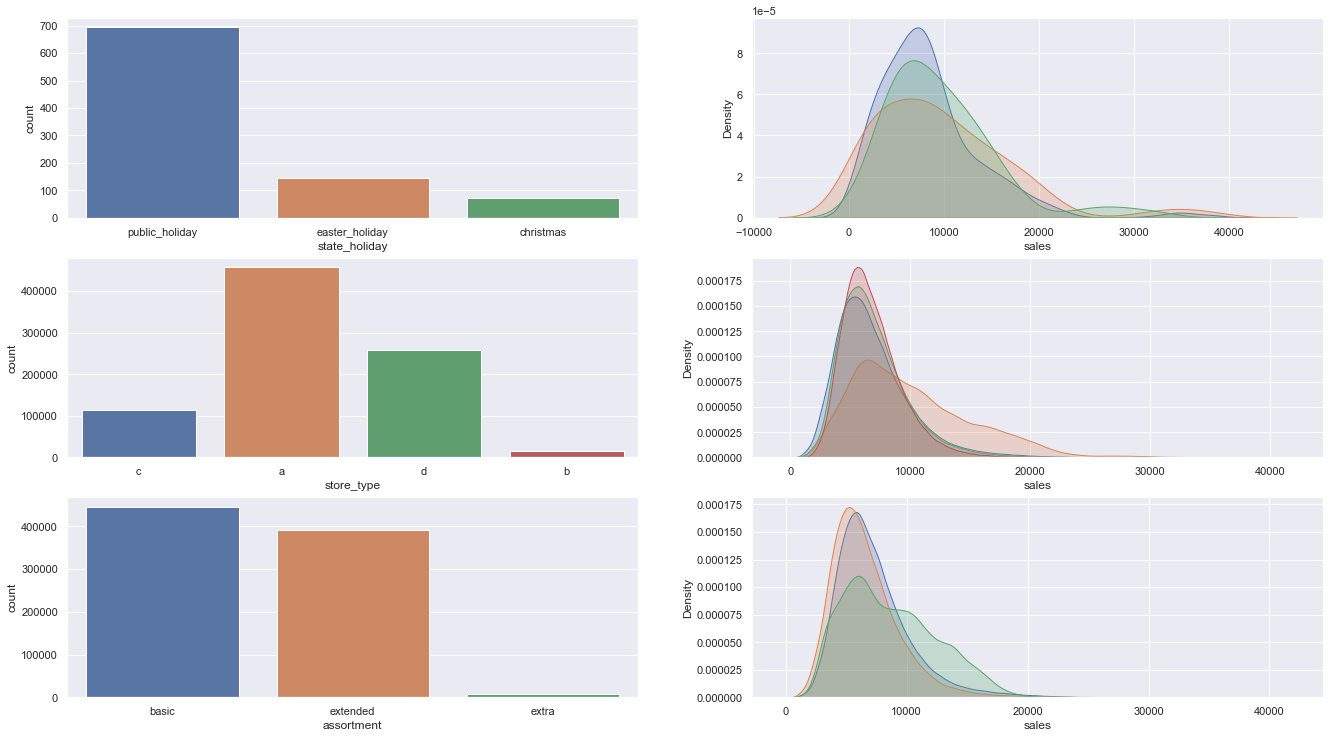

In [91]:
# state_holiday
plt.subplot( 3, 2, 1 )
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot( a['state_holiday'] )

plt.subplot( 3, 2, 2 )
sns.kdeplot( df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True )
sns.kdeplot( df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True )
sns.kdeplot( df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True )

# store_type
plt.subplot( 3, 2, 3 )
sns.countplot( df4['store_type'] )

plt.subplot( 3, 2, 4 )
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], label='a', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], label='b', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], label='c', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'd']['sales'], label='d', shade=True )

# assortment
plt.subplot( 3, 2, 5 )
sns.countplot( df4['assortment'] )

plt.subplot( 3, 2, 6 )
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True )
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True )
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True )

fig = plt.gcf()
fig.set_size_inches(22.5, 12.5)

# BIVARIATE ANALYSIS AND HYPOTESES TESTING

## H1. Stores with larger assortments should sell more.
### **FALSE** Stores with larger assortment sell less

<AxesSubplot:xlabel='year_week'>

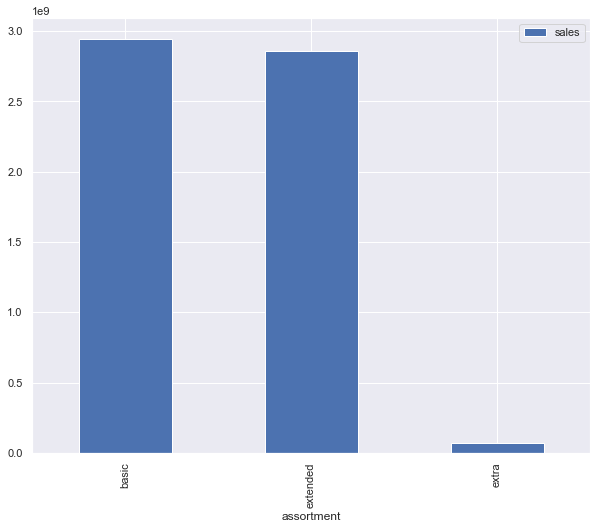

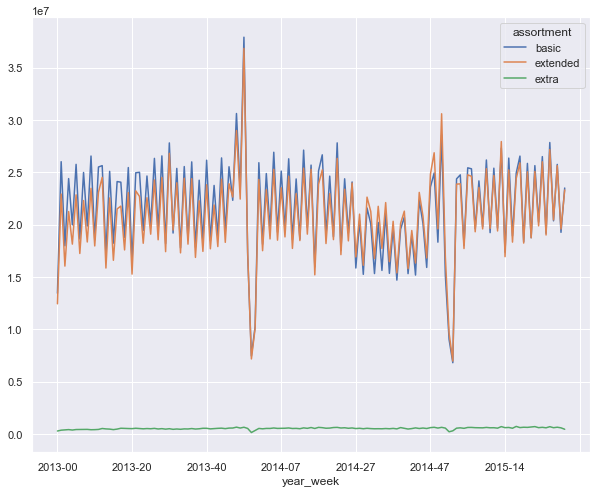

In [92]:
sns.set(rc={'figure.figsize':(10,8)})

df4.pivot_table(index='assortment',values='sales',aggfunc='sum').plot(kind='bar')

aux2 = df4[['year_week', 'assortment', 'sales']].groupby( ['year_week','assortment'] ).sum().reset_index()
aux2.pivot( index='year_week', columns='assortment', values='sales' ).plot()

## H2. Stores with closer competitors should sell less.
### **FALSE** Stores with CLOSER COMPETITORS sell LESS

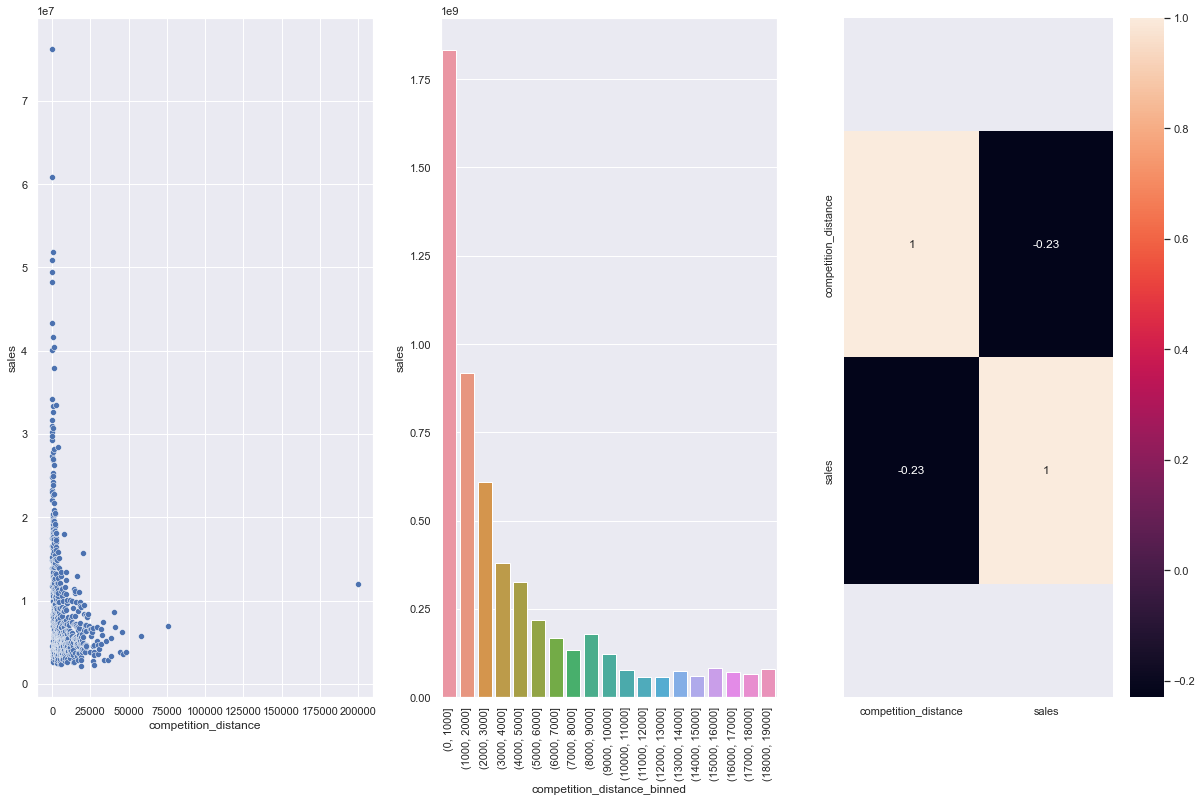

In [37]:
aux1 = df4[['competition_distance', 'sales']].groupby( 'competition_distance' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.scatterplot( x ='competition_distance', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
bins = list( np.arange( 0, 20000, 1000) )
aux1['competition_distance_binned'] = pd.cut( aux1['competition_distance'], bins=bins )
aux2 = aux1[['competition_distance_binned', 'sales']].groupby( 'competition_distance_binned' ).sum().reset_index()
sns.barplot( x='competition_distance_binned', y='sales', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot( 1, 3, 3 )
x = sns.heatmap( aux1.corr( method='pearson' ), annot=True );
bottom, top = x.get_ylim()
x.set_ylim( bottom+0.5, top-0.5 );

fig = plt.gcf()
fig.set_size_inches(20.5, 12.5)

## **H3.** Store with longer competitors should sell less
### **FALSE** Stores with LONGER COMPETITORS sell less

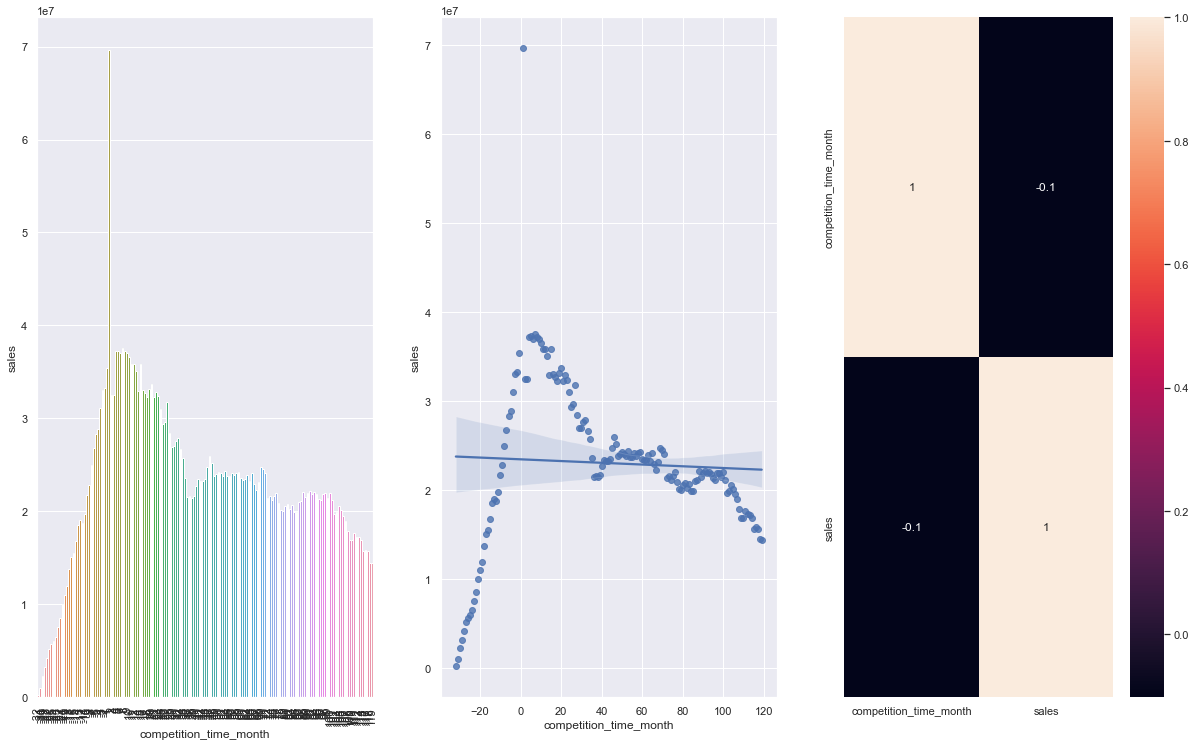

In [38]:
plt.subplot( 1, 3, 1 )
aux1 = df4[['competition_time_month', 'sales']].groupby( 'competition_time_month' ).sum().reset_index()
aux2 = aux1[( aux1['competition_time_month'] < 120 ) & ( aux1['competition_time_month'] != 0 )]
sns.barplot( x='competition_time_month', y='sales', data=aux2 )
plt.xticks( rotation=90 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='competition_time_month', y='sales', data=aux2 )

plt.subplot( 1, 3, 3 )
x = sns.heatmap( aux1.corr( method='pearson'), annot=True )
plt.xticks( rotation=0 );


fig = plt.gcf()
fig.set_size_inches(20.5, 12.5)

## **H4.** Stores with longer promotions should sell more.
### **FALSE** Stores with longer promotion sell less, after a certain period

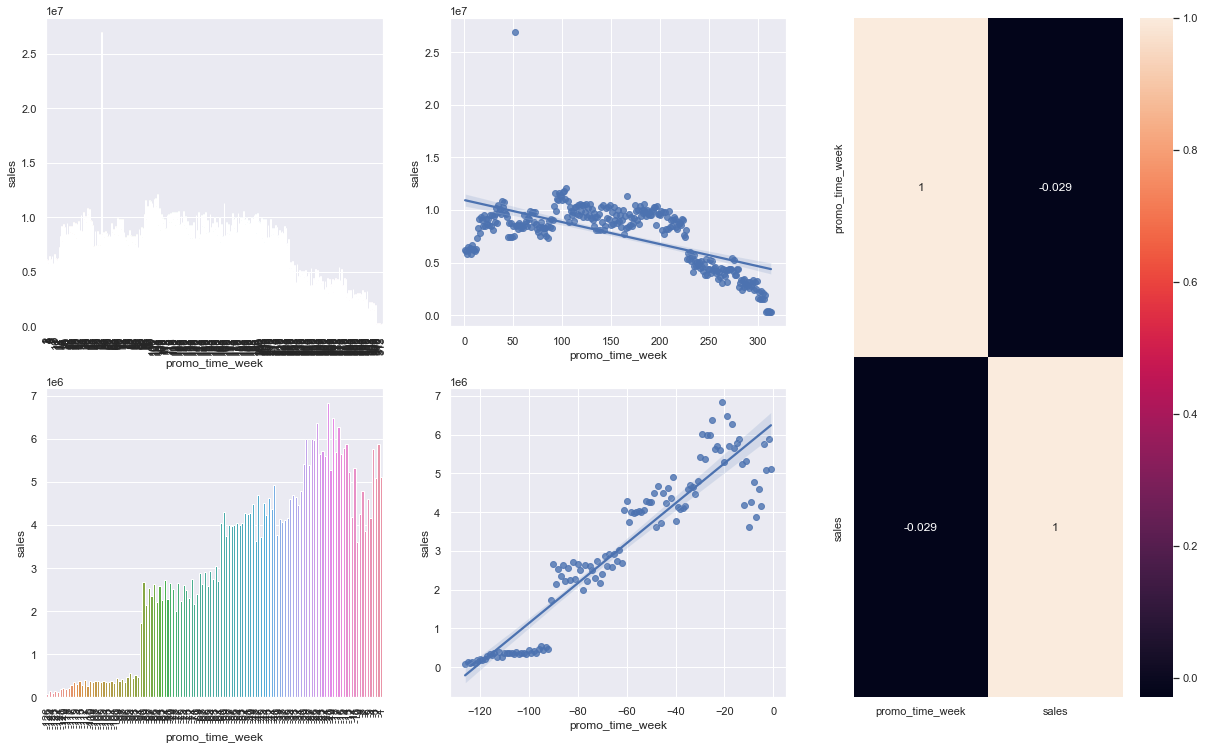

In [39]:
aux1 = df4[['promo_time_week', 'sales']].groupby( 'promo_time_week').sum().reset_index()

from matplotlib import gridspec

grid = gridspec.GridSpec( 2, 3 )

plt.subplot( grid[0,0] )
aux2 = aux1[aux1['promo_time_week'] > 0] # promo extendido
sns.barplot( x='promo_time_week', y='sales', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot( grid[0,1] )
sns.regplot( x='promo_time_week', y='sales', data=aux2 );

plt.subplot( grid[1,0] )
aux3 = aux1[aux1['promo_time_week'] < 0] # promo regular
sns.barplot( x='promo_time_week', y='sales', data=aux3 );
plt.xticks( rotation=90 );

plt.subplot( grid[1,1] )
sns.regplot( x='promo_time_week', y='sales', data=aux3 );

plt.subplot( grid[:,2] )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

fig = plt.gcf()
fig.set_size_inches(20.5, 12.5)

## <s>**H5.** Stores with more promotions days should sell more </s>

## **H7.** Stores with more consecutives promotions should sell more
### **FALSE** Stores with more consecutives promotions sell less

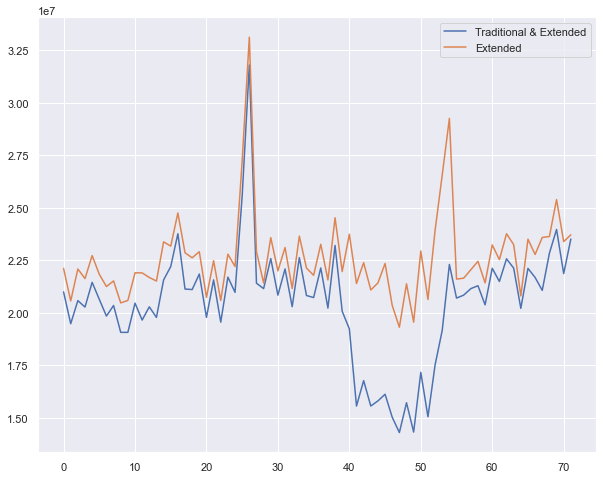

In [40]:
aux1 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 1 )][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()
ax = aux1.plot()

aux2 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 0 )][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()
aux2.plot( ax=ax )

ax.legend( labels=['Traditional & Extended', 'Extended']);

## H8 Stores open on Christmas Holiday should sell more.

###  **FALSE** Stores open on christmas holiday sell less.

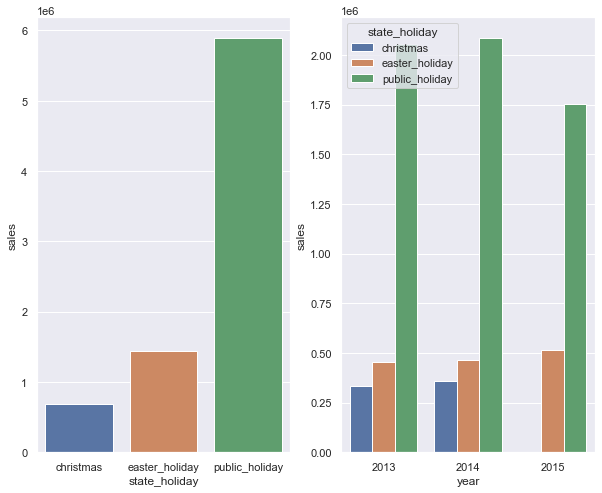

In [41]:
aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot( 1, 2, 1 )
aux1 = aux[['state_holiday', 'sales']].groupby( 'state_holiday' ).sum().reset_index()
sns.barplot( x='state_holiday', y='sales', data=aux1 );

plt.subplot( 1, 2, 2 )
aux2 = aux[['year', 'state_holiday', 'sales']].groupby( ['year', 'state_holiday'] ).sum().reset_index()
sns.barplot( x='year', y='sales', hue='state_holiday', data=aux2 );


## H9. Stores should sell more over the years.
###  **FALSE** Stores sell less over the years

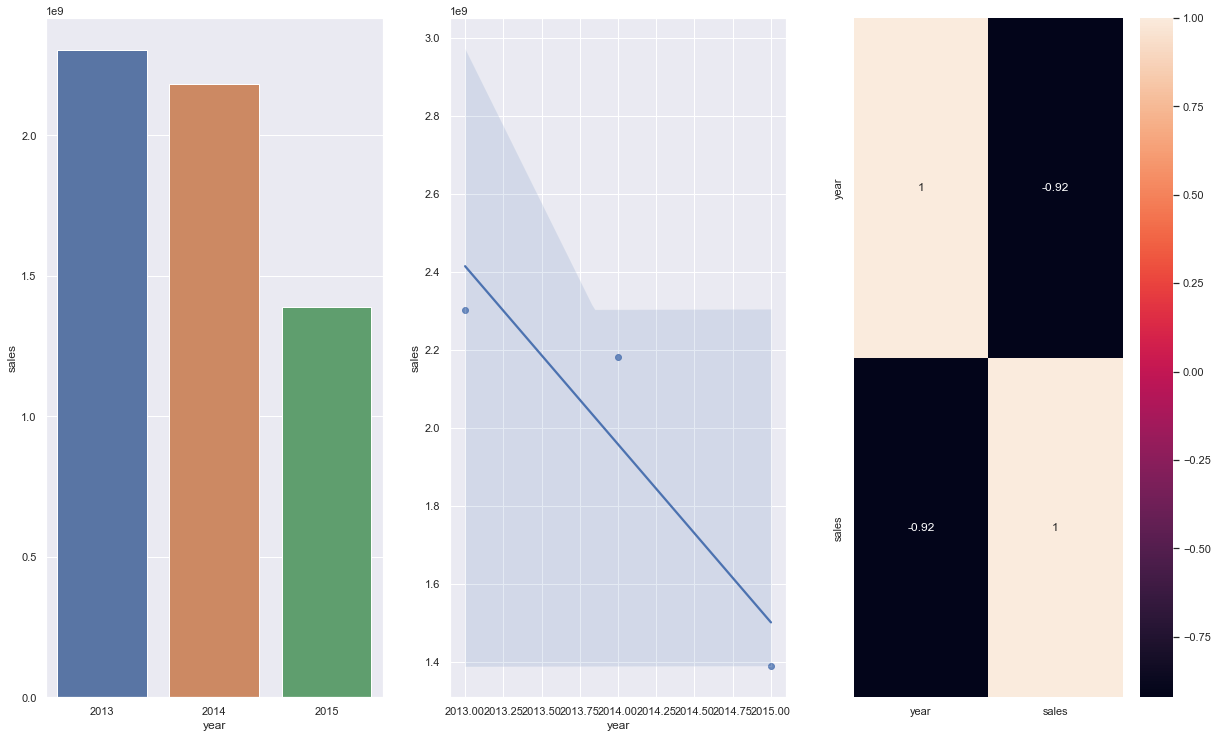

In [42]:
aux1 = df4[['year', 'sales']].groupby( 'year' ).sum().reset_index()

plt.subplot( 1, 3, 1)
sns.barplot( x='year', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='year', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );
plt.gcf().set_size_inches(20.5,12.5)

## H10 Stores should sell more in the second half of the year.
###  **FALSE** Stores sell less in the second half of the year

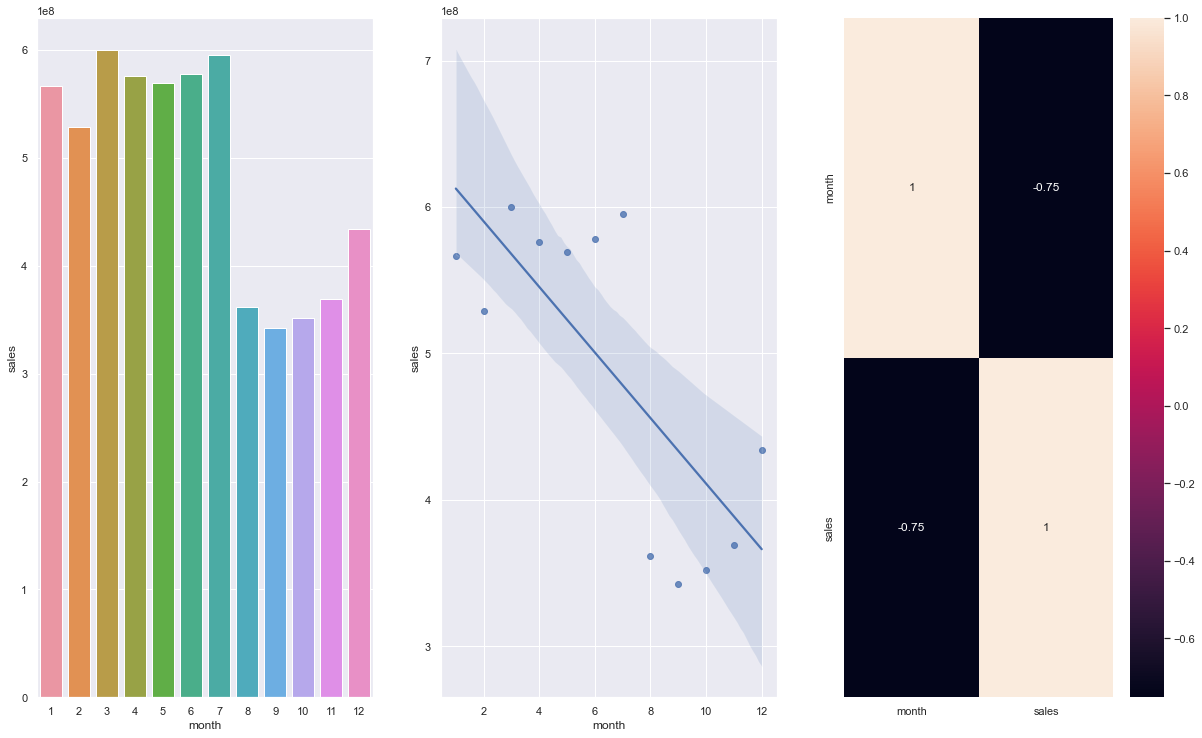

In [43]:
aux1 = df4[['month', 'sales']].groupby( 'month' ).sum().reset_index()

plt.subplot( 1, 3, 1)
sns.barplot( x='month', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='month', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );
plt.gcf().set_size_inches(20.5,12.5)

## H11 Stores should sell more after the 10th of each month.
###  **TRUE** Stores sell more after the 10th of each month.

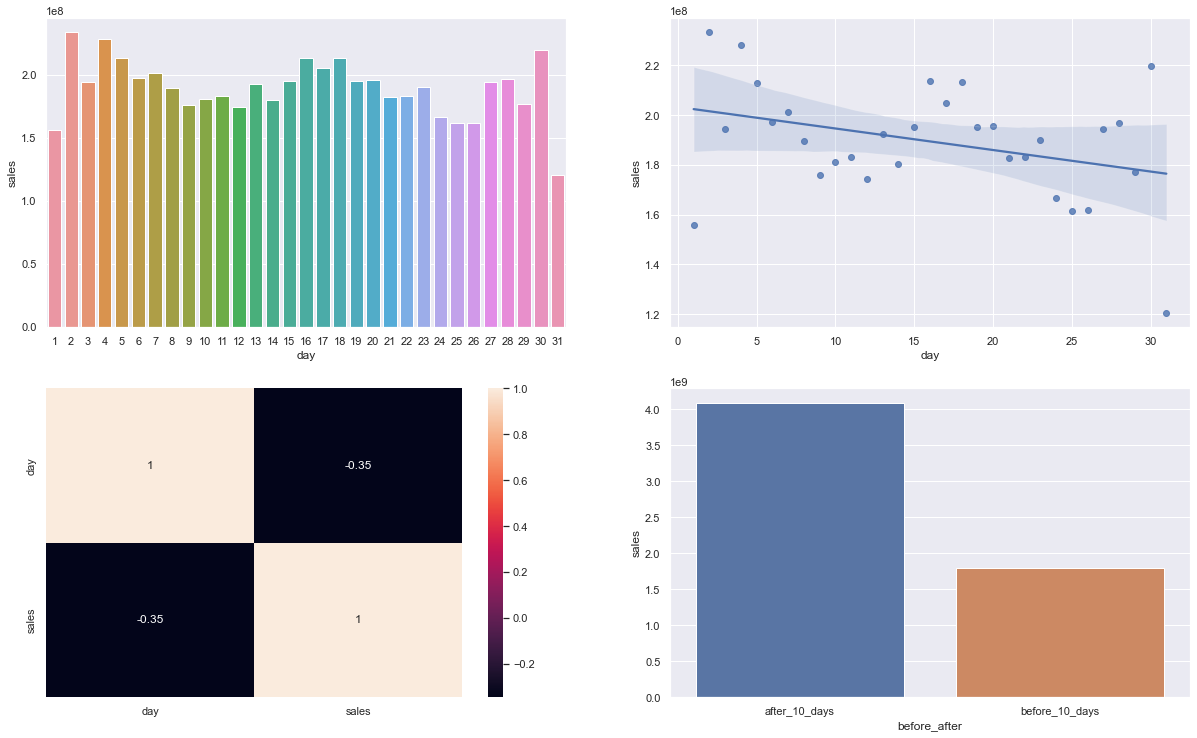

In [44]:
aux1 = df4[['day', 'sales']].groupby( 'day' ).sum().reset_index()

plt.subplot( 2, 2, 1)
sns.barplot( x='day', y='sales', data=aux1 );

plt.subplot( 2, 2, 2 )
sns.regplot( x='day', y='sales', data=aux1 );

plt.subplot( 2, 2, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );
plt.gcf().set_size_inches(20.5,12.5)


plt.subplot( 2, 2, 4)
aux1['before_after']= np.where(aux1['day']<10,'before_10_days','after_10_days')
aux2=aux1[['before_after','sales']].groupby( 'before_after').sum().reset_index()
sns.barplot(x='before_after',y='sales',data=aux2);

## H12 Stores should sell less on weekends.
###  **TRUE** Stores sell less after the 10th of each month.

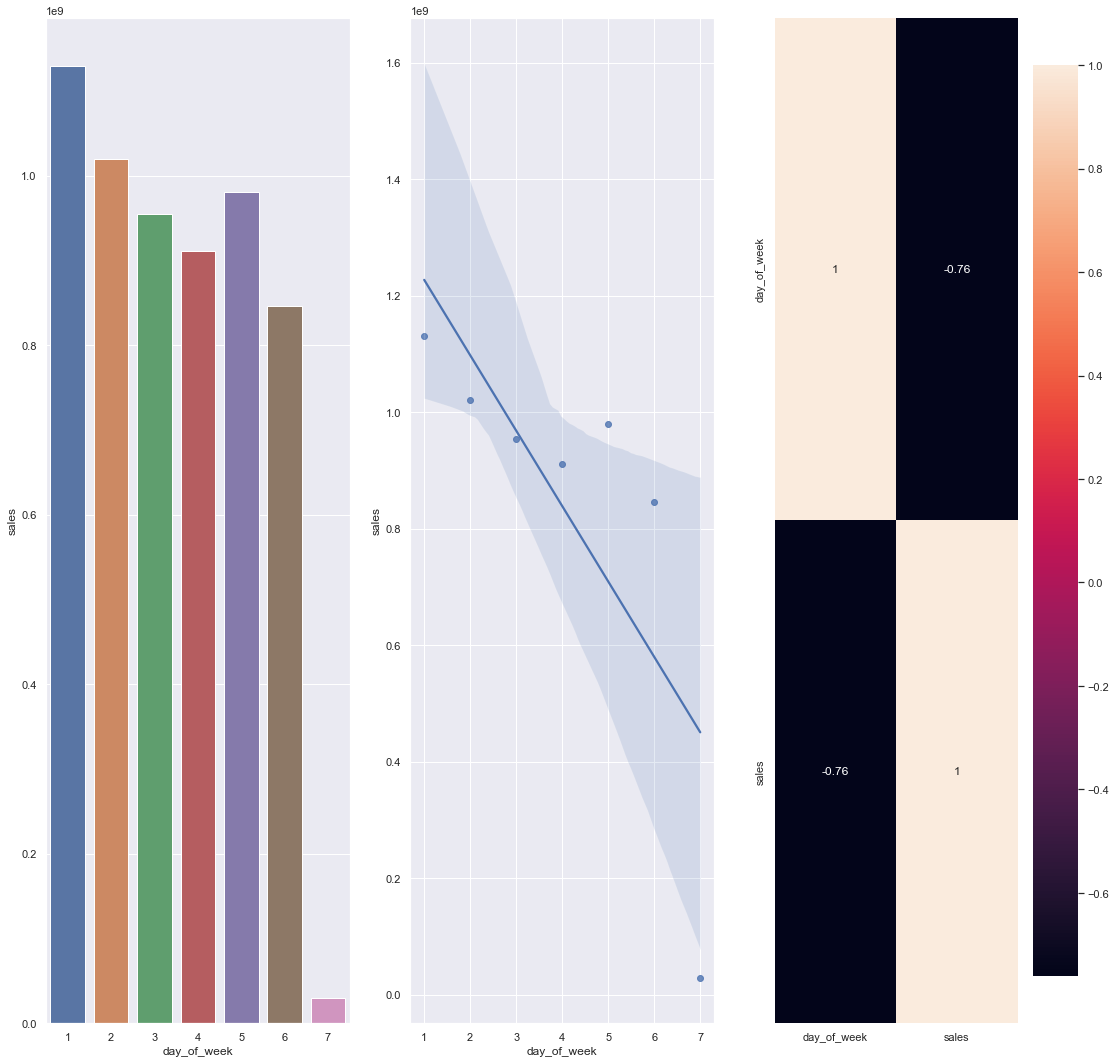

In [45]:
aux1 = df4[['day_of_week', 'sales']].groupby( 'day_of_week' ).sum().reset_index()

plt.subplot( 1, 3, 1)
sns.barplot( x='day_of_week', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='day_of_week', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );
plt.gcf().set_size_inches(18.5,18.5)

## H13 Stores should sell less during school holidays.
###  **TRUE** Stores sell less during school holidays, expect on July and August

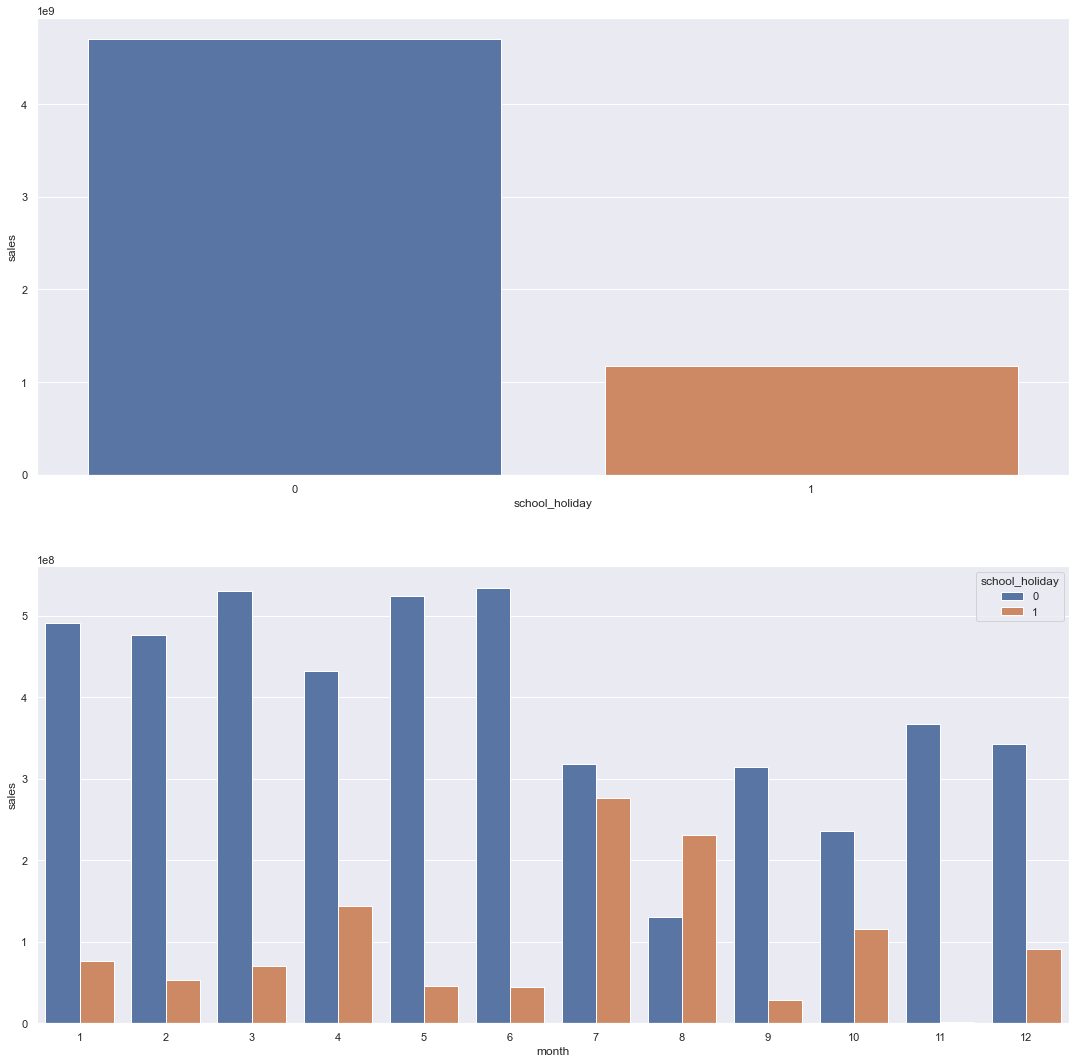

In [46]:
aux1 = df4[['school_holiday', 'sales']].groupby( 'school_holiday' ).sum().reset_index()
plt.subplot( 2, 1, 1 )
sns.barplot( x='school_holiday', y='sales', data=aux1 );

aux2 = df4[['month', 'school_holiday', 'sales']].groupby( ['month','school_holiday'] ).sum().reset_index()
plt.subplot( 2, 1, 2 )
sns.barplot( x='month', y='sales', hue='school_holiday', data=aux2 );
plt.gcf().set_size_inches(18.5,18.5)

# HYPOTESIS SUMMARY

In [47]:
hyp=[
['Hipothesis', 'Conclusion', "Relevance"],
["Stores with larger assortments should SELL MORE.",False,'Low'],
["Stores with closer competitors should SELL LESS.",False,'Medium'],
["Stores with longer competitors should SELL MORE.",False,'Medium'],
["Stores with longer active promotions should SELL MORE.",False,'Low'],
["Stores with more agressive promotions ( bigger discounts)  should SELL MORE ", 'Not testet yet','N/A'],
["Stores with more promotion days should SELL MORE.", 'Not testet yet','N/A']
["Stores with more consecutive promotions should SELL MORE.",False,'Low'],
["Stores open on the Christmas holiday should SELL MORE.",False,'Medium']],
["Stores should SELL MORE over the years.",False,'High'],
["Stores should SELL MORE in the second half of the year.",False,'High'],
["Stores should SELL MORE after the 10th of each month.",True, 'High'],
["Stores should SELL LESS on weekends.",True, 'High'],
["Stores should SELL LESS during school holidays.",True,'Low']
]


SyntaxError: unmatched ']' (480598798.py, line 16)

In [ ]:
Lojas com maior sortimentos deveriam vender mais.

Lojas com competidores mais próximos deveriam vender menos.

Lojas com competidores à mais tempo deveriam vendem mais.

# MULTIVARIATE ANALYSIS

## numerical attributes

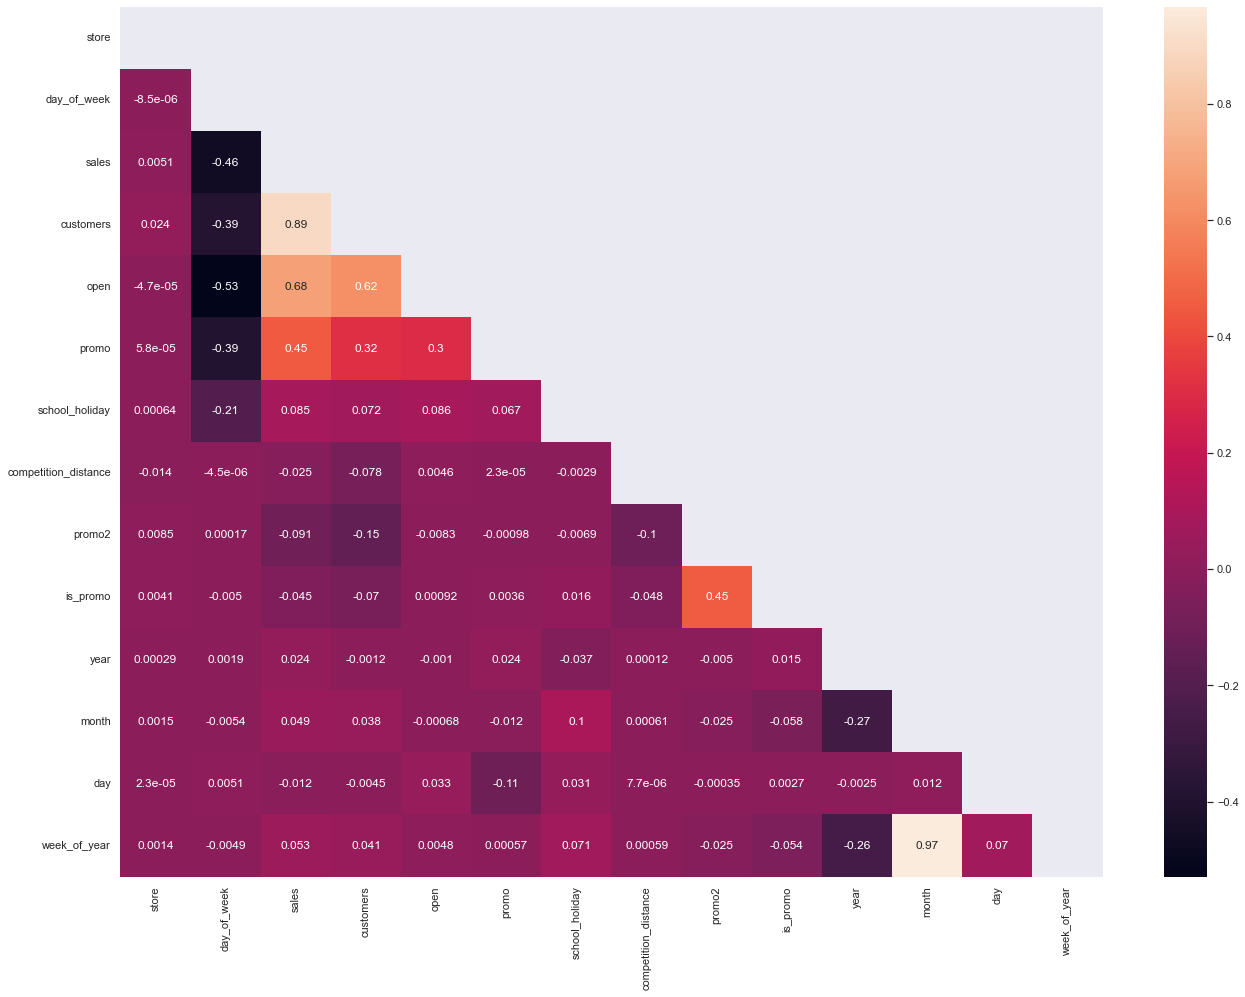

In [93]:
corrs= df2.select_dtypes(include=['float64','int64']).corr(method='pearson')
matrix = np.triu(corrs)
sns.heatmap(corrs,annot=True,mask=matrix)
plt.gcf().set_size_inches(22,16)

## categorical attributes

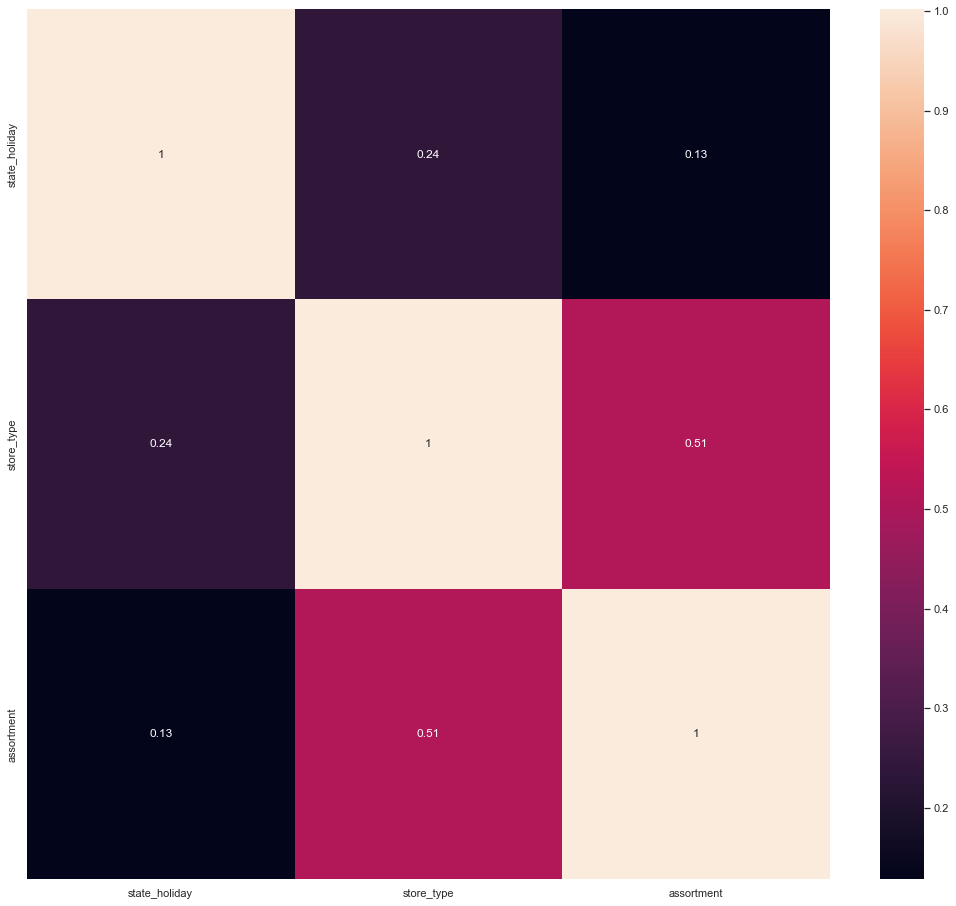

In [94]:
# Calculate cramer V
a1 = cramer_v( a['state_holiday'], a['state_holiday'] )
a2 = cramer_v( a['state_holiday'], a['store_type'] )
a3 = cramer_v( a['state_holiday'], a['assortment'] )

a4 = cramer_v( a['store_type'], a['state_holiday'] )
a5 = cramer_v( a['store_type'], a['store_type'] )
a6 = cramer_v( a['store_type'], a['assortment'] )

a7 = cramer_v( a['assortment'], a['state_holiday'] )
a8 = cramer_v( a['assortment'], a['store_type'] )
a9 = cramer_v( a['assortment'], a['assortment'] )

# Final dataset
d = pd.DataFrame( {'state_holiday': [a1, a2, a3], 
               'store_type': [a4, a5, a6],
               'assortment': [a7, a8, a9]  })
d = d.set_index( d.columns )

sns.heatmap( d, annot=True )
plt.gcf().set_size_inches(18,16)

# DATA PREPARATION

In [95]:
df5=df4.copy()

## normalization

## rescalling

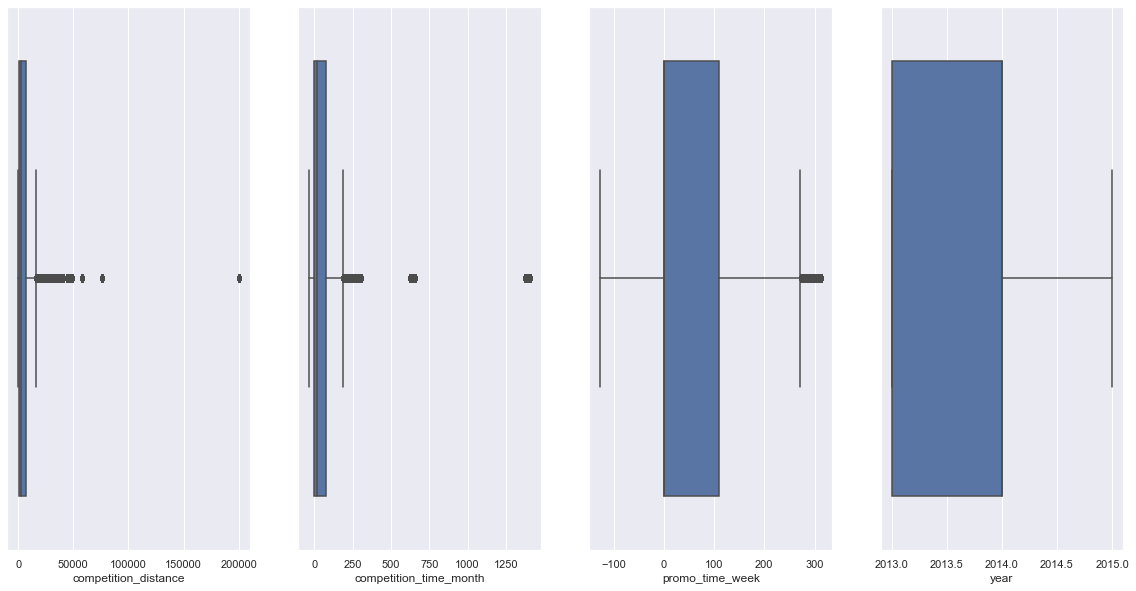

In [ ]:
plt.subplot(1,4,1)
sns.boxplot(df4['competition_distance'])
plt.subplot(1,4,2)
sns.boxplot(df4['competition_time_month'])
plt.subplot(1,4,3)
sns.boxplot(df4['promo_time_week'])
plt.subplot(1,4,4)
sns.boxplot(df4['year'])
plt.gcf().set_size_inches(20,10)


In [ ]:

rs = RobustScaler()
mms = MinMaxScaler()

os.makedirs("parameters",exist_ok=True)

# competition distance
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values )
pickle.dump( rs, open( 'parameters/competition_distance_scaler.pkl', 'wb') )

# competition time month
df5['competition_time_month'] = rs.fit_transform( df5[['competition_time_month']].values )
pickle.dump( rs, open( 'parameters/competition_time_month_scaler.pkl', 'wb') )

# promo time week
df5['promo_time_week'] = mms.fit_transform( df5[['promo_time_week']].values )
pickle.dump( rs, open( 'parameters/promo_time_week_scaler.pkl', 'wb') )

# year
df5['year'] = mms.fit_transform( df5[['year']].values )
pickle.dump( mms, open( 'parameters/year_scaler.pkl', 'wb') )

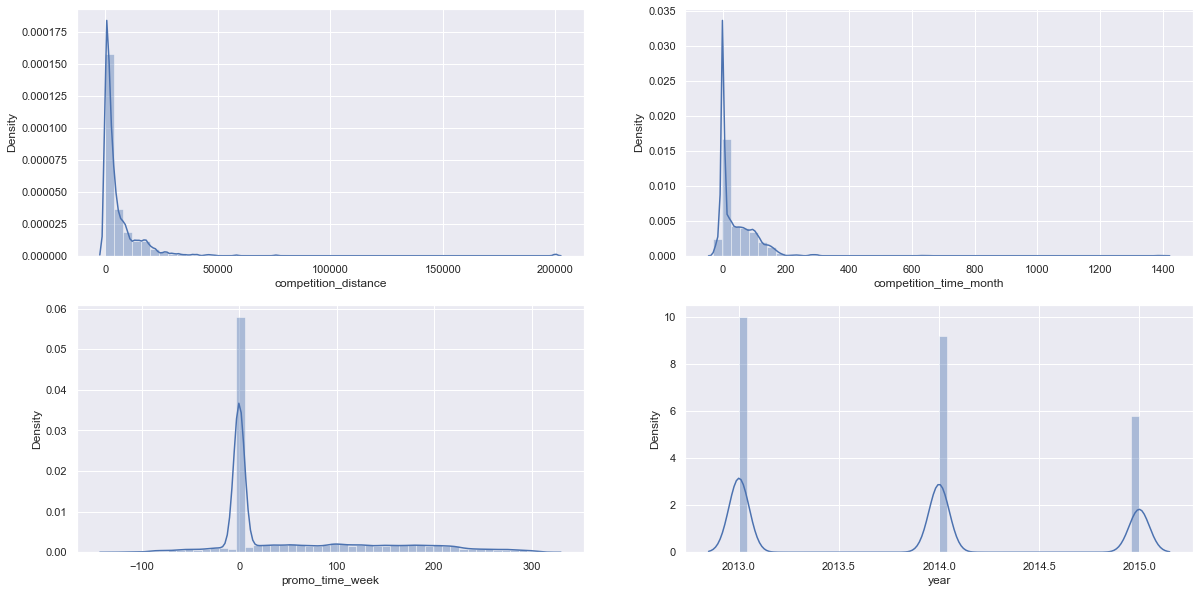

In [ ]:
plt.subplot(2,2,1)
sns.distplot(df4['competition_distance'])
plt.subplot(2,2,2)
sns.distplot(df4['competition_time_month'])
plt.subplot(2,2,3)
sns.distplot(df4['promo_time_week'])
plt.subplot(2,2,4)
sns.distplot(df4['year'])
plt.gcf().set_size_inches(20,10)

## encoding

In [96]:
#One Hot Encoding

df5=pd.get_dummies(df5,prefix=['state_holiday'],columns=['state_holiday'])

#LabelEncoder
le=LabelEncoder()
df5['store_type']=le.fit_transform(df5['store_type'])
pickle.dump(le,open("parameters/store_type_scaler.pkl","wb"))

#Ordinal Encoder
assortment_dict = {'basic':1 , "extra": 2, "extended":3}
df5['assortment'] = df5['assortment'].map(assortment_dict)
#pickle.dump(rs,open("parameters/assortment_encoder.pkl","wb"))

df5.head()

NameError: name 'rs' is not defined

## Target Variable Transformation

In [ ]:
df5['sales'] = np.log1p(df5['sales'])

## Nature Transformation

In [ ]:
# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )

# month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

# day 
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )

# FEATURE SELECTION

## Split dataframe into training and test dataset

In [ ]:
df6=df5.copy()

In [ ]:
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']
df6= df6.drop(cols_drop, axis=1)

In [ ]:
df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days=6*7)

Timestamp('2015-06-19 00:00:00')

In [ ]:

train= df6[df6['date']<'2015-06-19']
test = df6[df6['date']>='2015-06-19']

xtrain, ytrain = train.drop(['sales'],axis=1), train['sales']
xtest, ytest = test.drop(['sales'], axis=1), test['sales']

print(f"Train size: {xtrain.shape}, {xtrain['date'].max()} \n",
    f"Test size: {xtest.shape}, {xtest['date'].min()}")

Train size: (802942, 28), 2015-06-18 00:00:00 
 Test size: (41396, 28), 2015-06-19 00:00:00


## Boruta as Feature Selector

## Manual Feature Selection

In [46]:
cols_selected_boruta = [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_sin',
    'month_cos',
    'day_sin',
    'day_cos',
    'week_of_year_sin',
    'week_of_year_cos']
len(cols_selected_boruta)

20

In [ ]:
cols_selected_boruta = [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_sin',
    'month_cos',
    'day_sin',
    'day_cos',
    'week_of_year_sin',
    'week_of_year_cos']

# columns to add
feat_to_add = ['date', 'sales']

cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )

# MACHINE LEARNING MODELLING

In [ ]:
xtrain=train[cols_selected_boruta]
xtest=test[cols_selected_boruta]
xtrainfull=train[cols_selected_boruta_full]

In [ ]:
def errors_ml(ytrue,ypred,model_name=None):
    mae_baseline=mean_absolute_error(np.expm1(ytrue),np.expm1(ypred))
    mape_baseline=mean_absolute_percentage_error(np.expm1(ytrue),np.expm1(ypred))
    mse_baseline=mean_squared_error(np.expm1(ytrue),np.expm1(ypred))
    rmse_baseline=np.sqrt(mse_baseline)
    results=pd.DataFrame(data={'model_name':model_name,'mae':mae_baseline,'mape':mape_baseline,'mse':mse_baseline,'rmse':rmse_baseline}, index=[0])
    return results

## Average Model

In [ ]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)


aux1 = xtest.copy()
aux1['sales'] = ytest.copy()

# prediction
aux2 = aux1[['store', 'sales']].groupby( 'store' ).mean().reset_index().rename( columns={'sales': 'predictions'} )
aux1 = pd.merge( aux1, aux2, how='left', on='store' )
ypred_baseline = aux1['predictions']

# performance
baseline_result = errors_ml(aux1['sales'],ypred_baseline,model_name='average_model')
baseline_result

NameError: name 'pd' is not defined

## Linear Regression Model

In [ ]:
# model
lr = LinearRegression().fit( xtrain, ytrain )

# prediction
ypred_lr = lr.predict( xtest )

# performance
lr_result = errors_ml(ytest, ypred_lr,model_name=lr.__class__.__name__)
lr_result

,model_name,mae,mape,mse,rmse
0,LinearRegression,1867.08977,0.29269,7134503.90969,2671.04922


## Linear Regression Model - Cross Validation

In [ ]:
# model
lrr = Lasso( alpha=0.01 ).fit( xtrain, ytrain )

# prediction
ypred_lrr = lrr.predict( xtest )

# performance
lrr_result = errors_ml(ytest, ypred_lrr,model_name=lrr.__class__.__name__)
lrr_result

,model_name,mae,mape,mse,rmse
0,Lasso,1891.70488,0.28911,7532015.33699,2744.45174


## Random Forest Regressor

In [ ]:
# model
rf = RandomForestRegressor(n_estimators=15, n_jobs=-1,  max_depth=25, random_state=42).fit( xtrain, ytrain )

# prediction
ypred_rf = rf.predict( xtest )

# performance
rf_result = errors_ml(ytest, ypred_rf,model_name=rf.__class__.__name__)
rf_result

,model_name,mae,mape,mse,rmse
0,RandomForestRegressor,733.13469,0.10679,1194321.76834,1092.85030


## XGBoost Regressor

In [ ]:
# model
model_xgb = xgb.XGBRegressor(colsample_bytree=0.6,gamma=0.3,learning_rate=0.1,max_depth=15,
min_child_weight=3,subsample=0.9,n_estimators=50,eval_metric='rmse',early_stopping_rounds=20,random_state=42).fit( xtrain, ytrain )

# prediction
ypred_xgb = model_xgb.predict( xtest )
# performance
xgb_result = errors_ml(ytest, ypred_xgb,model_name=model_xgb.__class__.__name__)
xgb_result

[05:11:08] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




,model_name,mae,mape,mse,rmse
0,XGBRegressor,940.36205,0.12634,1981111.28621,1407.51955


## Compare Models Performance

In [ ]:
modelling_result=pd.concat([baseline_result,lr_result,lrr_result,rf_result,xgb_result])
modelling_result.sort_values("rmse")

,model_name,mae,mape,mse,rmse
0,RandomForestRegressor,733.13469,0.10679,1194321.76834,1092.85030
0,XGBRegressor,940.36205,0.12634,1981111.28621,1407.51955
0,average_model,1354.80035,0.20640,3367722.45872,1835.13554
0,LinearRegression,1867.08977,0.29269,7134503.90969,2671.04922
0,Lasso,1891.70488,0.28911,7532015.33699,2744.45174


## Cross Validation

In [ ]:
def cross_validation( x_training, kfold, model_name, model, verbose=False ):
    mae_list = []
    mape_list = []
    rmse_list = []
    print(f'training {model_name}')
    for k in reversed( range( 1, kfold+1 ) ):
        if verbose:
            print( '\nKFold Number: {}'.format( k ) )
        # start and end date for validation 
        validation_start_date = x_training['date'].max() - datetime.timedelta( days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta( days=(k-1)*6*7)

        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # training and validation dataset
        # training
        xtraining = training.drop( ['date', 'sales'], axis=1 ) 
        ytraining = training['sales']

        # validation
        xvalidation = validation.drop( ['date', 'sales'], axis=1 )
        yvalidation = validation['sales']

        # model
        m = model.fit( xtraining, ytraining )

        # prediction
        yhat = m.predict( xvalidation )

        # performance
        m_result = errors_ml( yvalidation, yhat, model_name=model_name)




        # store performance of each kfold iteration
        mae_list.append(  m_result['mae'] )
        mape_list.append( m_result['mape'] )
        rmse_list.append( m_result['rmse'] )

    return pd.DataFrame( {'Model Name': model_name,
                          'MAE CV': np.round( np.mean( mae_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
                          'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),
                          'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str ) }, index=[0] )

## Hyperparameter Tuning

In [ ]:
params = {"colsample_bytree":[ 0.7, 0.9],
"learning_rate": [0.1],
"max_depth":[10,15,20],
"min_child_weight":[2,3,4], 
"subsample": [ 0.7,0.9],
"gamma": [0.3,0.4],
"n_estimators":[50,75],
"eval_metric":['rmse'],
"early_stopping_rounds":[20],
"random_state":[42]}

## Final Model

In [50]:
param_tuned = {
'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 20, 'min_child_weight': 4,
 'subsample': 0.7, 'gamma': 0.3, 'n_estimators': 50, 'eval_metric': 'rmse', 'early_stopping_rounds': 20,
  'random_state': 42
        }

In [51]:
def mean_percentage_error (y, ypred):
    return np.mean((y - ypred)/y )

In [52]:
mpe = mean_absolute_percentage_error( np.expm1 (ytest), np.expm1(ypred_xgb_tuned))
mpe

NameError: name 'ytest' is not defined

# ERROR INTERPRETATION TO BUSINESS

In [ ]:
cols_selected_boruta_full

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_sin',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_sin',
 'week_of_year_cos',
 'date',
 'sales']

In [53]:
df9 = test[cols_selected_boruta_full]

# rescale
df9['sales'] = np.expm1( df9['sales'])
df9['predictions']= np.expm1(ypred_xgb_tuned)
df9.head(1)

NameError: name 'cols_selected_boruta_full' is not defined

## business performance

In [ ]:
# sum of predictions
df91 = df9[['store', 'predictions']].groupby( 'store' ).sum().reset_index()

# MAE and MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby( 'store' ).apply( lambda x: mean_absolute_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAE'})
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby( 'store' ).apply( lambda x: mean_absolute_percentage_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAPE'})

# Merge
df9_aux3 = pd.merge( df9_aux1, df9_aux2, how='inner', on='store' )
df92 = pd.merge( df91, df9_aux3, how='inner', on='store' )

# Scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

# order columns
df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

<AxesSubplot:xlabel='store', ylabel='MAPE'>

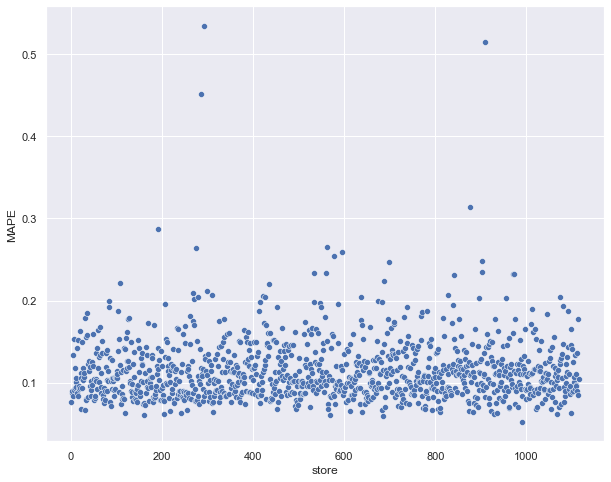

In [ ]:
sns.scatterplot(x='store',y='MAPE',data=df92)

In [ ]:
df92.sort_values( 'MAPE', ascending=False ).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,102837.30469,99522.55777,106152.05160,3314.74692,0.53418
908,909,208463.70312,200388.53460,216538.87165,8075.16852,0.51542
285,286,189815.26562,188372.88003,191257.65122,1442.38559,0.45154
875,876,180474.18750,176157.09301,184791.28199,4317.09449,0.31389
191,192,342641.09375,338712.52832,346569.65918,3928.56543,0.28691


## total performance

In [ ]:
df93=df92[['predictions','worst_scenario','best_scenario']].apply(lambda x: np.sum(x),axis=0).reset_index().rename(columns={'index':'Scenario',0:'Values'})
df93['Values']=df93['Values'].map( 'R${:,.2f}'.format )
df93

,Scenario,Values
0,predictions,"R$267,868,336.00"
1,worst_scenario,"R$266,907,597.52"
2,best_scenario,"R$268,829,090.00"


## machine learning performance

In [ ]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

NameError: name 'df9' is not defined

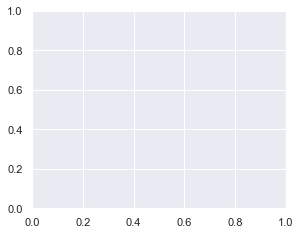

In [49]:
plt.subplot( 2, 2, 1 )
sns.lineplot( x='date', y='sales', data=df9, label='SALES' )
sns.lineplot( x='date', y='predictions', data=df9, label='PREDICTIONS' )

plt.subplot( 2, 2, 2 )
sns.lineplot( x='date', y='error_rate', data=df9 )
plt.axhline( 1, linestyle='--')

plt.subplot( 2, 2, 3 )
sns.distplot( df9['error'] )

plt.subplot( 2, 2, 4 )
sns.scatterplot( df9['predictions'], df9['error'] )

# DEPLOY MODEL TO PRODUCTION

## Rossmann class

In [54]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime

class Rossmann( object ):
    def __init__( self ):
        self.home_path='P:\Python\GitHub\forecast_sales'
        self.competition_distance_scaler   = pickle.load( open( self.home_path + '\parameters\competition_distance_scaler.pkl', 'rb') )
        self.competition_time_month_scaler = pickle.load( open( self.home_path + '\parameters\competition_time_month_scaler.pkl', 'rb') )
        self.promo_time_week_scaler        = pickle.load( open( self.home_path + '\parameters\promo_time_week_scaler.pkl', 'rb') )
        self.year_scaler                   = pickle.load( open( self.home_path + '\parameters\year_scaler.pkl', 'rb') )
        self.store_type_scaler             = pickle.load( open( self.home_path + '\parameters\store_type_scaler.pkl', 'rb') )
        
        
    def data_cleaning( self, df1 ): 
        
        ## 1.1. Rename Columns
        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 
                    'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
                    'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

        snakecase = lambda x: inflection.underscore( x )

        cols_new = list( map( snakecase, cols_old ) )

        # rename
        df1.columns = cols_new

        ## 1.3. Data Types
        df1['date'] = pd.to_datetime( df1['date'] )

      
        #fillna competition_distance        
        df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan( x ) else x )

        #competition_open_since_month
        df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 )

        #competition_open_since_year 
        df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1 )

        #promo2_since_week           
        df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )

        #promo2_since_year           
        df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )

        #promo_interval              
        month_map = {1: 'Jan',  2: 'Fev',  3: 'Mar',  4: 'Apr',  5: 'May',  6: 'Jun',  7: 'Jul',  8: 'Aug',  9: 'Sep',  10: 'Oct', 11: 'Nov', 12: 'Dec'}

        df1['promo_interval'].fillna(0, inplace=True )

        df1['month_map'] = df1['date'].dt.month.map( month_map )

        df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )

        # change data type competiton
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )

        # change data type promo2
        df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
        df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )
        
        return df1 


    def feature_engineering( self, df2 ):

        # year
        df2['year'] = df2['date'].dt.year

        # month
        df2['month'] = df2['date'].dt.month

        # day
        df2['day'] = df2['date'].dt.day

        # week of year
        df2['week_of_year'] = df2['date'].dt.weekofyear

        # year week
        df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

        # competition since
        df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1 ), axis=1 )
        df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( int )

        # promo since
        df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
        df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
        df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( int )

        # assortment
        df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

        # state holiday
        df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )

     
        # row filtering
        df2 = df2[df2['open'] != 0]

        # col filtering
        cols_drop = ['open', 'promo_interval', 'month_map']
        df2 = df2.drop( cols_drop, axis=1 )
        
        return df2


    def data_preparation( self, df5 ):

        ## 5.2. Rescaling 
        # competition distance
        df5['competition_distance'] = self.competition_distance_scaler.transform( df5[['competition_distance']].values )
    
        # competition time month
        df5['competition_time_month'] = self.competition_time_month_scaler.transform( df5[['competition_time_month']].values )
d
        # promo time week
        df5['promo_time_week'] = self.promo_time_week_scaler.transform( df5[['promo_time_week']].values )
        
        # year
        df5['year'] = self.year_scaler.transform( df5[['year']].values )

        ### 5.3.1. Encoding
        # state_holiday - One Hot Encoding
        df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )

        # store_type - Label Encoding
        df5['store_type'] = self.store_type_scaler.transform( df5['store_type'] )

        # assortment - Ordinal Encoding
        assortment_dict = {'basic': 1,  'extra': 2, 'extended': 3}
        df5['assortment'] = df5['assortment'].map( assortment_dict )

        
        ### 5.3.3. Nature Transformation
        # day of week
        df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
        df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )

        # month
        df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
        df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

        # day 
        df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
        df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

        # week of year
        df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
        df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )
        
        
        cols_selected = [ 'store', 'promo', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month',
            'competition_open_since_year', 'promo2', 'promo2_since_week', 'promo2_since_year', 'competition_time_month', 'promo_time_week',
            'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 'week_of_year_sin', 'week_of_year_cos']
        
        return df5[ cols_selected ]
    
    
    def get_prediction( self, model, original_data, test_data ):
        # prediction
        pred = model.predict( test_data )
        
        # join pred into the original data
        original_data['prediction'] = np.expm1( pred )
        
        return original_data.to_json( orient='records', date_format='iso' )

## API handler

In [13]:
import pickle
import pandas as pd
from flask             import Flask, request, Response
from rossmann import rossmann
import inflection

# loading model
model = pickle.load( open(r'P:\\Python\\GitHub\\forecast_sales\\model_xgb_rossmann_v0.pkl', 'rb') )

# initialize API
app = Flask( __name__ )

@app.route( '/rossmann/predict', methods=['POST'] )
def rossmann_predict():
    test_json = request.get_json()
   
    if test_json: # there is data
        if isinstance( test_json, dict ): # unique example
            test_raw = pd.DataFrame( test_json, index=[0] )
            
        else: # multiple example
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() )
            
        # Instantiate Rossmann class
        pipeline = Rossmann()
        
        # data cleaning
        df1 = pipeline.data_cleaning( test_raw )
        
        # feature engineering
        df2 = pipeline.feature_engineering( df1 )
        
        # data preparation
        df3 = pipeline.data_preparation( df2 )
        
        # prediction
        df_response = pipeline.get_prediction( model, test_raw, df3 )
        
        return df_response
        
        
    else:
        return Response( '{}', status=200, mimetype='application/json' )

if __name__ == '__main__':
    app.run( '0.0.0.0' )

ModuleNotFoundError: No module named 'rossmann'

## API tester

In [119]:
#loading test dataset
df10=pd.read_csv(r"data/test.csv")
df10.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


In [120]:
# merge test dataset +store
df_test=df10.merge(store,how='left',on='Store')

#choose store for prediction
df_test = df_test[df_test['Store'] == 22]

#remove closed days
df_test=df_test[(df_test['Open']!=0) & (~df_test['Open'].isnull())]


In [121]:
df_test.head(1)

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
15,16,22,4,2015-09-17,1.0,1,0,0,a,a,1040.0,NaN,NaN,1,22.0,2012.0,"Jan,Apr,Jul,Oct"


In [122]:
len(df_test.columns)

17

In [123]:
# convert Dataframe to json
import json
import requests
data = json.dumps(df_test.to_dict(orient='records'))

In [124]:
#API Call
url = 'http://192.168.1.10:5000/rossmann/predict'

data=data

header = {'Content-type': 'application/json','debug':'True'}

r=requests.post(url, data, headers=header)
print( f'Status Code {r.status_code}')

Status Code 200


In [125]:
d1 = pd.DataFrame( r.json(), columns=r.json()[0].keys())

In [126]:
d1.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,prediction
0,16,22,4,2015-09-17,1.0,1,0,0,a,a,1040.0,None,None,1,22.0,2012.0,"Jan,Apr,Jul,Oct",4674.521973
1,872,22,3,2015-09-16,1.0,1,0,0,a,a,1040.0,None,None,1,22.0,2012.0,"Jan,Apr,Jul,Oct",4385.039062
2,1728,22,2,2015-09-15,1.0,1,0,0,a,a,1040.0,None,None,1,22.0,2012.0,"Jan,Apr,Jul,Oct",5403.807617
3,2584,22,1,2015-09-14,1.0,1,0,1,a,a,1040.0,None,None,1,22.0,2012.0,"Jan,Apr,Jul,Oct",6495.707520
4,4296,22,6,2015-09-12,1.0,0,0,0,a,a,1040.0,None,None,1,22.0,2012.0,"Jan,Apr,Jul,Oct",3049.921875


In [127]:
d1['prediction'].describe()

count      40.000000
mean     4361.729791
std       958.739221
min      2937.240234
25%      3652.235352
50%      4174.822754
75%      4924.368530
max      6595.819824
Name: prediction, dtype: float64

In [128]:
d2 = d1[['Store', 'prediction']].groupby( 'Store' ).sum().reset_index()

for i in range( len( d2 ) ):
    print( 'Store Number {} will sell R${:,.2f} in the next 6 weeks'.format( 
            d2.loc[i, 'Store'], 
            d2.loc[i, 'prediction'] ) )

Store Number 22 will sell R$174,469.19 in the next 6 weeks


In [10]:
!pip freeze > requirements.txt

In [12]:
!pip list --format=freeze  > requirements.txt